# 数字图像特征练习(Image features exercise)

*完成并提交本作业（包括代码输出和作业之外的所有支持代码）。 有关更多详情，请参阅课程网站上的[作业提交页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)。*

通过训练输入图像的像素上的线性分类器，我们可以在图像分类任务上达到较好的效果。 在本次练习中，我们将要提高分类的性能，同样是训练线性分类器，但是不是基于在原始的像素，而是基于从原始像素上计算得到的特征(features)。

本练习的所有工作都将在这个notebook上完成。

In [8]:
import random 
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(10.0, 8.0) # 设置图的大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 对于自动加载的外部模块
# 详见 http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 加载数据

和之前的练习类似，我们将会从磁盘存储上加载 CIFAR-10 数据集。


In [10]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_DATA(num_training=49000, num_validation=1000, num_test=1000):
    # 加载 CIFAR-10 数据
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    #对数据进行子采样
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# 训练集 验证集 测试集
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_DATA()    

In [11]:
print(u"训练集输入 X_train 大小："+str(X_train.shape))
print(u"训练集标签 y_train 大小："+str(y_train.shape))

print(u"验证集输入 X_val 大小："+str(X_val.shape))
print(u"验证集标签 y_val 大小："+str(y_val.shape))

print(u"测试集输入 X_test 大小："+str(X_test.shape))
print(u"测试集标签 y_test 大小："+str(y_test.shape))


训练集输入 X_train 大小：(49000L, 32L, 32L, 3L)
训练集标签 y_train 大小：(49000L,)
验证集输入 X_val 大小：(1000L, 32L, 32L, 3L)
验证集标签 y_val 大小：(1000L,)
测试集输入 X_test 大小：(1000L, 32L, 32L, 3L)
测试集标签 y_test 大小：(1000L,)


## 提取特征

对于每一幅图像，我们将计算出其面向方向梯度的直方图（HOG，a Histogram of Oriented Gradients）以及其使用HSV颜色空间中的色调通道的颜色直方图（a color histogram using the hue channel in HSV color space）。我们通过连接HOG和颜色直方图特征向量来形成每个图像的最终特征向量。

总的来说，HOG能够描述图像的纹理而忽略其颜色信息，颜色直方图能表征输入图像的颜色而忽略其纹理。 因此，我们期望两者结合使用应该比单独使用更好。 验证这个假设对于附加部分（译者注：本门课程的附加题）来说很有帮助。

hog_feature和color_histogram_hsv函数参数都是单幅图像，返回的是该图像的特征向量。 extract_features函数参数是一个图像集合和特征函数列表，并评估每幅图像上的每个特征函数，将结果存储在矩阵中，其中每列是单个图像的所有特征向量的拼接。

In [12]:
from cs231n.features import *

num_color_bins = 10 # 彩色直方图中的分组数
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin = num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# 预处理之减去平均值特征
mean_feat = np.mean(X_train_feats, axis=0,keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# 预处理之除以标准差，这一步确保每一个特征值都落在同一个范围内
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# 预处理之加上偏差维度
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [17]:
a =np.array([1, 2, 3, 4, 5])
print(a)
print(a.shape)
a_mean = np.mean(a)
print(a_mean)
print(a_mean.shape)

a = np.reshape(a,5,1)
a_mean = np.mean(a)
print(a.shape)
print(a_mean)

[1 2 3 4 5]
(5L,)
3.0
()
(5L,)
3.0


## 在特征中训练支持向量机（Support Vector Machine, SVM）

基于提取的特征训练 SVM，其中用的是前面作业所实现的多种 SVM 实现代码 ；这将比直接在原始像素上直接训练 SVM 能获得更好的结果。

In [18]:
# 使用验证集来调节学习率和在正则化强度

from cs231n.classifiers.linear_classifier import LinearSVM 

# learning_rates =  [1e-9, 1e-8, 1e-7]
# regularization_strengths = [1e5, 1e6, 1e7]
learning_rates = [5e-9, 7.5-9, 1e-8]
regularization_strengths = [(5+i)*1e6 for i in range(-3, 4)]

results ={}
best_val = -1
best_svm = None

################################################################################
# 通过
# 待完善:
# 使用验证集来设置学习率以及正则化强度,这和在 SVM 上所做的验证相同
# 将最好的分类器保存到 best_svm 中
# 你也可以在彩色直方图中使用不同的分类数(bins)来验证
# 如果整个过程严谨验证，在验证集上大致会得到约 0.44 的正确率。
################################################################################

for rs in regularization_strengths:
    for lr in learning_rates:
        svm =  LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, lr, rs, num_iters=6000)
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        results[(lr, rs)] = train_accuracy, val_accuracy
#通过
################################################################################
#                             代码结束                              #
################################################################################

# 输出结果
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("lr(学习率) %e reg(正则化) %e"%(lr, reg))
    print("train accuracy(训练精确度):%f val accuracy(验证精确度):%f"%(train_accuracy, val_accuracy))

print("交叉验证中最优的验证精确度为: %f"%best_val)    
        

lr(学习率) -1.500000e+00 reg(正则化) 2.000000e+06
train accuracy(训练精确度):0.100265 val accuracy(验证精确度):0.087000
lr(学习率) -1.500000e+00 reg(正则化) 3.000000e+06
train accuracy(训练精确度):0.100265 val accuracy(验证精确度):0.087000
lr(学习率) -1.500000e+00 reg(正则化) 4.000000e+06
train accuracy(训练精确度):0.100265 val accuracy(验证精确度):0.087000
lr(学习率) -1.500000e+00 reg(正则化) 5.000000e+06
train accuracy(训练精确度):0.100265 val accuracy(验证精确度):0.087000
lr(学习率) -1.500000e+00 reg(正则化) 6.000000e+06
train accuracy(训练精确度):0.100265 val accuracy(验证精确度):0.087000
lr(学习率) -1.500000e+00 reg(正则化) 7.000000e+06
train accuracy(训练精确度):0.100265 val accuracy(验证精确度):0.087000
lr(学习率) -1.500000e+00 reg(正则化) 8.000000e+06
train accuracy(训练精确度):0.100265 val accuracy(验证精确度):0.087000
lr(学习率) 5.000000e-09 reg(正则化) 2.000000e+06
train accuracy(训练精确度):0.413694 val accuracy(验证精确度):0.411000
lr(学习率) 5.000000e-09 reg(正则化) 3.000000e+06
train accuracy(训练精确度):0.412000 val accuracy(验证精确度):0.420000
lr(学习率) 5.000000e-09 reg(正则化) 4.000000e+06
train accuracy(训练精确度):0

In [20]:
# 在测试集上评估训练好的 SVM
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print("测试精确度：%f"%test_accuracy)

测试精确度：0.419000


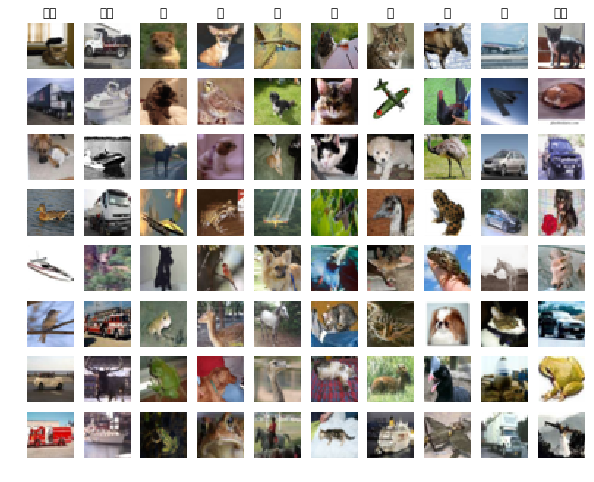

In [23]:
examples_per_class = 8

# classes = [u'飞机', u'汽车', u'鸟', u'猫', u'鹿', u'犬', u'蛙', u'马', u'船', u'卡车']
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test!=cls)&(y_test_pred==cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i*len(classes)+cls+1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i ==0:
            plt.title(cls_name)
plt.show()            
    


描述一下你所看到的错误分类结果，它们这样分类是否有道理？、

由于我们使用了彩色直方图特征以及 HOG 特征来
Since we are using The color histogram features and the HOG features for some misclassification results which have special background or outline, they do make sense. For example, the objects which have a blue background tend to be misclassified as plane and some dogs(trucks) tend be misclassified as cat(car).

## 基于图像特征的神经网络

我们已经看到在原始像素上训练两层神经网络比直接在原始像素线性分类器有更好的分类效果。通过本编程任务我们能够知道，基于图像特征的线性分类器效果又优于基于原始像素的线性分类器。

In [25]:
print(X_train_feats.shape)

(49000L, 155L)


In [28]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

## 附加任务：设计自己的特征

看到了吧，简单的图像特征就可以提高计算机对图像分类的表现。目前我们尝试了使用 HOG 和 颜色直方图，有没有更好的特征来得到更好的分类效果呢？

作为奖励分数，设计一种新的特征，将其用于在 CIFAR-10 的图像分类任务中，解释你的特征是如何生效的以及其为什么能够其能提升分类性能。在本 notebook 中实现它，交叉验证任何必须的超参数，并将其得到的模型性能指标和通过 HOG+彩色直方图模型得到的性能进行对比。

## 附加任务：额外的挑战

用编程任务提供的材料和代码来做一些你觉得很有意思的事情，以及你是否还有一些其他的疑问要问呢？在完成这个任务的过程中，你脑中是否迸发出了很棒很酷的点子以及头脑风暴？那么动手将这些想法变成现实！让你在伙伴们面前展示的机会到了！